In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.stats import norm, skew
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ml-dataset/sample_submission.csv
/kaggle/input/ml-dataset/test.csv
/kaggle/input/ml-dataset/train.csv
/kaggle/input/fare-classification/meta_data.csv


In [2]:
train = pd.read_csv("../input/ml-dataset/train.csv")
test = pd.read_csv("../input/ml-dataset/test.csv")
IDtest = test["tripid"]

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17176 entries, 0 to 17175
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   tripid                     17176 non-null  int64  
 1   additional_fare            16974 non-null  float64
 2   duration                   16974 non-null  float64
 3   meter_waiting              16974 non-null  float64
 4   meter_waiting_fare         16974 non-null  float64
 5   meter_waiting_till_pickup  16974 non-null  float64
 6   pickup_time                17176 non-null  object 
 7   drop_time                  17176 non-null  object 
 8   pick_lat                   17176 non-null  float64
 9   pick_lon                   17176 non-null  float64
 10  drop_lat                   17176 non-null  float64
 11  drop_lon                   17176 non-null  float64
 12  fare                       17039 non-null  float64
 13  label                      17176 non-null  obj

In [4]:
train.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
4,189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct


In [5]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers

In [6]:
Outliers_to_drop = detect_outliers(train,2,["additional_fare","duration","meter_waiting","meter_waiting_fare","meter_waiting_till_pickup"
                                           ,"pick_lat","pick_lon","drop_lat","drop_lon"])

In [7]:
train.loc[Outliers_to_drop]

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
25,189160756,10.5,358.0,66.0,0.0000,79.0,11/1/2019 8:51,11/1/2019 8:57,6.05858,80.2003,6.05566,80.1810,210.58,incorrect
34,189164791,10.5,286.0,44.0,0.0000,9.0,11/1/2019 9:23,11/1/2019 9:28,7.48628,80.6206,7.47984,80.6233,545.89,incorrect
51,189182800,10.5,220.0,10.0,0.0000,27.0,11/1/2019 11:34,11/1/2019 11:37,7.48995,80.3639,7.49838,80.3715,71.84,correct
84,189227008,10.5,2159.0,1158.0,67.5114,344.0,11/1/2019 14:31,11/1/2019 15:07,7.32514,80.6521,7.29959,80.6366,274.56,correct
115,189250944,10.5,1301.0,10.0,0.0000,60.0,11/1/2019 16:43,11/1/2019 17:05,7.31738,80.6995,7.33181,80.6289,356.51,correct
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16751,213125070,10.5,1748.0,80.0,0.0000,37.0,1/29/2020 20:42,1/29/2020 21:11,7.29311,80.6370,7.33452,80.6823,431.96,correct
16944,213372335,10.5,300.0,1.0,0.0583,66.0,1/30/2020 17:48,1/30/2020 17:53,7.30790,80.6371,7.32106,80.6387,99.53,correct
16966,213397557,30.5,777.0,54.0,0.0000,128.0,1/30/2020 18:53,1/30/2020 19:06,7.29334,80.6361,7.32462,80.6355,239.43,correct
17037,213521569,10.5,659.0,40.0,0.0000,87.0,1/31/2020 10:39,1/31/2020 10:50,7.29424,80.6335,7.32501,80.6311,177.47,correct


In [8]:
# train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [9]:
train.shape

(17176, 14)

In [10]:
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [11]:
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

tripid                          0
additional_fare               202
duration                      202
meter_waiting                 202
meter_waiting_fare            202
meter_waiting_till_pickup     202
pickup_time                     0
drop_time                       0
pick_lat                        0
pick_lon                        0
drop_lat                        0
drop_lon                        0
fare                          137
label                        8576
dtype: int64

In [12]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17176 entries, 0 to 17175
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   tripid                     17176 non-null  int64  
 1   additional_fare            16974 non-null  float64
 2   duration                   16974 non-null  float64
 3   meter_waiting              16974 non-null  float64
 4   meter_waiting_fare         16974 non-null  float64
 5   meter_waiting_till_pickup  16974 non-null  float64
 6   pickup_time                17176 non-null  object 
 7   drop_time                  17176 non-null  object 
 8   pick_lat                   17176 non-null  float64
 9   pick_lon                   17176 non-null  float64
 10  drop_lat                   17176 non-null  float64
 11  drop_lon                   17176 non-null  float64
 12  fare                       17039 non-null  float64
 13  label                      17176 non-null  obj

tripid                         0
additional_fare              202
duration                     202
meter_waiting                202
meter_waiting_fare           202
meter_waiting_till_pickup    202
pickup_time                    0
drop_time                      0
pick_lat                       0
pick_lon                       0
drop_lat                       0
drop_lon                       0
fare                         137
label                          0
dtype: int64

In [13]:
train.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
4,189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct


In [14]:
train.dtypes

tripid                         int64
additional_fare              float64
duration                     float64
meter_waiting                float64
meter_waiting_fare           float64
meter_waiting_till_pickup    float64
pickup_time                   object
drop_time                     object
pick_lat                     float64
pick_lon                     float64
drop_lat                     float64
drop_lon                     float64
fare                         float64
label                         object
dtype: object

In [15]:
train.describe()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare
count,1.717600e+04,16974.000000,16974.000000,16974.000000,16974.000000,16974.000000,17176.000000,17176.000000,17176.000000,17176.000000,17039.000000
mean,2.014549e+08,13.719651,1702.858077,629.074231,32.057666,112.466832,6.965499,79.998389,6.968587,79.997534,312.655466
std,7.456830e+06,98.975052,8120.160818,8063.260669,465.483573,442.054812,0.210760,0.243384,0.378669,0.359648,605.300565
min,1.891236e+08,0.000000,0.000000,0.000000,0.000000,0.000000,5.937600,79.819100,5.941860,45.307700,0.000000
25%,1.947619e+08,10.500000,548.000000,33.000000,0.000000,26.000000,6.865077,79.870400,6.865625,79.870100,125.515000
50%,2.013582e+08,10.500000,1009.500000,123.000000,0.116600,73.000000,6.914105,79.898600,6.916160,79.899100,211.180000
75%,2.083081e+08,10.500000,1803.000000,351.000000,14.341800,144.000000,7.043057,79.956600,7.047195,79.960225,366.465000
max,2.138173e+08,12795.030000,453872.000000,453650.000000,26198.601400,51288.000000,8.051010,81.009600,48.132000,81.009700,26945.990000


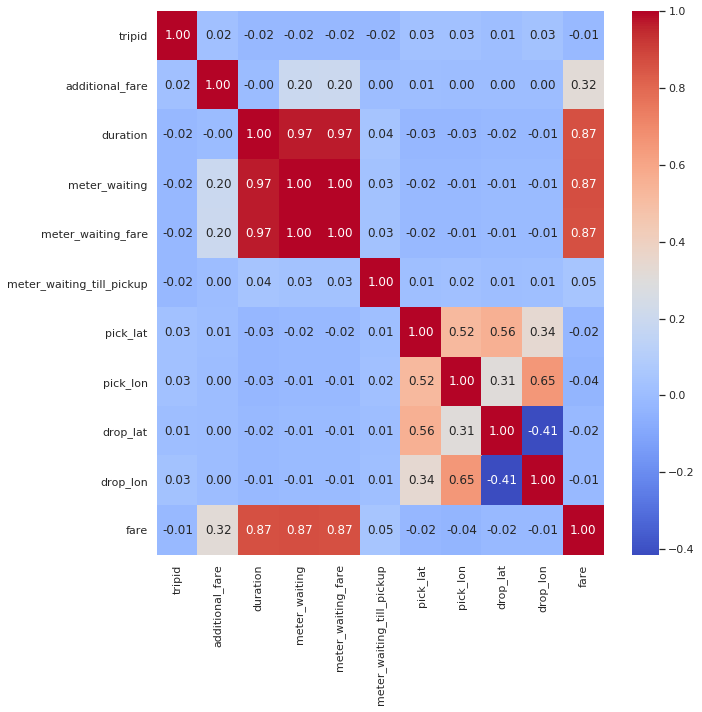

In [16]:
plt.figure(figsize=[10,10])
sns.heatmap(train.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

In [17]:
dataset["fare"] = dataset["fare"].fillna(dataset["fare"].median())
dataset["additional_fare"] = dataset["additional_fare"].fillna(dataset["additional_fare"].median())
dataset["duration"] = dataset["duration"].fillna(dataset["duration"].median())
dataset["meter_waiting"] = dataset["meter_waiting"].fillna(dataset["meter_waiting"].median())
dataset["meter_waiting_fare"] = dataset["meter_waiting"].fillna(dataset["meter_waiting"].median())
dataset["meter_waiting_till_pickup"] = dataset["meter_waiting"].fillna(dataset["meter_waiting"].median())

In [18]:
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

tripid                          0
additional_fare                 0
duration                        0
meter_waiting                   0
meter_waiting_fare              0
meter_waiting_till_pickup       0
pickup_time                     0
drop_time                       0
pick_lat                        0
pick_lon                        0
drop_lat                        0
drop_lon                        0
fare                            0
label                        8576
dtype: int64

In [19]:
dataset.head()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,189123628,10.5,834.0,56.0,56.0,56.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
1,189125358,10.5,791.0,47.0,47.0,47.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
2,189125719,10.5,1087.0,80.0,80.0,80.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
3,189127273,10.5,598.0,271.0,271.0,271.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
4,189128020,10.5,1000.0,121.0,121.0,121.0,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct


In [20]:
dataset.drop(labels = ["tripid"], axis = 1, inplace = True)

In [21]:
# numeric_feats = dataset.dtypes[dataset.dtypes != "object"].index

# # Check the skew of all numerical features
# skewed_feats = dataset[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
# print("\nSkew in numerical features: \n")
# skewness = pd.DataFrame({'Skew' :skewed_feats})
# skewness.head(15)

In [22]:
# skewness = skewness[abs(skewness) > 0.75]
# print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

# from scipy.special import boxcox1p
# skewed_features = skewness.index
# lam = 0.15
# for feat in skewed_features:
#     #all_data[feat] += 1
#     dataset[feat] = boxcox1p(dataset[feat], lam)

In [23]:
# numeric_feats = dataset.dtypes[dataset.dtypes != "object"].index

# # Check the skew of all numerical features
# skewed_feats = dataset[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
# print("\nSkew in numerical features: \n")
# skewness = pd.DataFrame({'Skew' :skewed_feats})
# skewness.head(15)

In [24]:
dataset.describe()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare
count,25752.000000,25752.000000,25752.000000,25752.000000,25752.000000,25752.000000,25752.000000,25752.000000,25752.000000,25752.000000
mean,12.818028,1643.639057,584.935617,584.935617,584.935617,6.966747,80.001832,6.969061,80.001733,305.649469
std,80.423381,7434.251664,7348.380453,7348.380453,7348.380453,0.213136,0.246287,0.334039,0.327857,553.232339
min,0.000000,0.000000,0.000000,0.000000,0.000000,5.937600,79.817700,5.936600,45.307700,0.000000
25%,10.500000,548.000000,32.000000,32.000000,32.000000,6.865003,79.870700,6.865428,79.870500,126.050000
50%,10.500000,1000.000000,121.000000,121.000000,121.000000,6.913915,79.899200,6.915905,79.900000,208.730000
75%,10.500000,1764.000000,342.250000,342.250000,342.250000,7.049340,79.958800,7.053997,79.962800,357.782500
max,12795.030000,453872.000000,453650.000000,453650.000000,453650.000000,8.425010,81.009600,48.132000,81.009700,26945.990000


In [25]:
dataset.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,10.5,834.0,56.0,56.0,56.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct
1,10.5,791.0,47.0,47.0,47.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct
2,10.5,1087.0,80.0,80.0,80.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct
3,10.5,598.0,271.0,271.0,271.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct
4,10.5,1000.0,121.0,121.0,121.0,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,correct


In [26]:
dataset.drop(labels = ["pickup_time"], axis = 1, inplace = True)
dataset.drop(labels = ["drop_time"], axis = 1, inplace = True)

In [27]:
dataset.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,10.5,834.0,56.0,56.0,56.0,6.86252,79.8993,6.90330,79.8783,270.32,correct
1,10.5,791.0,47.0,47.0,47.0,6.88589,79.8984,6.91373,79.8923,197.85,correct
2,10.5,1087.0,80.0,80.0,80.0,6.90839,79.8651,6.93669,79.9146,301.64,correct
3,10.5,598.0,271.0,271.0,271.0,6.92570,79.8895,6.92748,79.8971,82.30,correct
4,10.5,1000.0,121.0,121.0,121.0,6.87441,79.8615,6.84478,79.9290,358.39,correct


In [28]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["label"],axis = 1,inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17176 entries, 0 to 17175
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   additional_fare            17176 non-null  float64
 1   duration                   17176 non-null  float64
 2   meter_waiting              17176 non-null  float64
 3   meter_waiting_fare         17176 non-null  float64
 4   meter_waiting_till_pickup  17176 non-null  float64
 5   pick_lat                   17176 non-null  float64
 6   pick_lon                   17176 non-null  float64
 7   drop_lat                   17176 non-null  float64
 8   drop_lon                   17176 non-null  float64
 9   fare                       17176 non-null  float64
 10  label                      17176 non-null  object 
dtypes: float64(10), object(1)
memory usage: 1.4+ MB


In [30]:
train["label"] = train["label"].map({"correct": 1, "incorrect":0})

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17176 entries, 0 to 17175
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   additional_fare            17176 non-null  float64
 1   duration                   17176 non-null  float64
 2   meter_waiting              17176 non-null  float64
 3   meter_waiting_fare         17176 non-null  float64
 4   meter_waiting_till_pickup  17176 non-null  float64
 5   pick_lat                   17176 non-null  float64
 6   pick_lon                   17176 non-null  float64
 7   drop_lat                   17176 non-null  float64
 8   drop_lon                   17176 non-null  float64
 9   fare                       17176 non-null  float64
 10  label                      17176 non-null  int64  
dtypes: float64(10), int64(1)
memory usage: 1.4 MB


In [32]:
test.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare
17176,10.5,924.0,42.0,42.0,42.0,6.83454,79.8750,6.77490,79.8840,289.27
17177,10.5,4249.0,20.0,20.0,20.0,6.91168,79.8723,6.55091,79.9706,1912.70
17178,10.5,1552.0,255.0,255.0,255.0,6.92145,79.8478,6.90539,79.8989,394.00
17179,10.5,462.0,16.0,16.0,16.0,6.77433,79.9416,6.80401,79.9407,154.32
17180,10.5,814.0,392.0,392.0,392.0,6.97968,79.9130,6.98875,79.8914,147.47


In [33]:
Y_train = train["label"]

X_train = train.drop(labels = ["label"],axis = 1)

In [34]:
X_train=X_train[["additional_fare","duration","meter_waiting","meter_waiting_till_pickup","meter_waiting_fare","fare"]]
test=test[["additional_fare","duration","meter_waiting","meter_waiting_till_pickup","meter_waiting_fare","fare"]]

In [35]:
X_train.shape

(17176, 6)

In [36]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
test = scaler.transform(test)

In [37]:
X_train.shape

(17176, 6)

In [38]:
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True))

In [39]:
batch_size = 50
x1_data = tf.placeholder(shape=[None, 1], dtype=tf.float32)
x2_data = tf.placeholder(shape=[None, 1], dtype=tf.float32)
x3_data = tf.placeholder(shape=[None, 1], dtype=tf.float32)
x4_data = tf.placeholder(shape=[None, 1], dtype=tf.float32)
x5_data = tf.placeholder(shape=[None, 1], dtype=tf.float32)
x6_data = tf.placeholder(shape=[None, 1], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)
w1 = tf.Variable(tf.random_normal(shape=[1, 1]))
w2 = tf.Variable(tf.random_normal(shape=[1, 1]))
w3 = tf.Variable(tf.random_normal(shape=[1, 1]))
w4 = tf.Variable(tf.random_normal(shape=[1, 1]))
w5 = tf.Variable(tf.random_normal(shape=[1, 1]))
w6 = tf.Variable(tf.random_normal(shape=[1, 1]))
b = tf.Variable(tf.random_normal(shape=[1, 1]))

In [40]:
xw1 = tf.matmul(x1_data, w1)
xw2 = tf.matmul(x2_data, w2)
xw3 = tf.matmul(x3_data, w3)
xw4 = tf.matmul(x4_data, w4)
xw5 = tf.matmul(x5_data, w5)
xw6 = tf.matmul(x6_data, w6)
o1 = tf.add(xw1,xw2)
o2 = tf.add(o1,xw3)
o3 = tf.add(o2,xw4)
o4 = tf.add(o3,xw5)
o5 = tf.add(o4,xw6)
my_output = tf.add(o5,b)

In [41]:
xentropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=my_output,labels=y_target)

In [42]:
my_opt = tf.train.GradientDescentOptimizer(0.05)
train_step = my_opt.minimize(xentropy)

In [43]:
init = tf.initialize_all_variables()
sess.run(init)

In [44]:
for i in range(50000):
    rand_index = np.random.choice(len(X_train),size=batch_size)
    rand_x = X_train[rand_index]
    rand_x1 = np.array([[x[0]] for x in rand_x])
    rand_x2 = np.array([[x[1]] for x in rand_x])
    rand_x3 = np.array([[x[2]] for x in rand_x])
    rand_x4 = np.array([[x[3]] for x in rand_x])
    rand_x5 = np.array([[x[4]] for x in rand_x])
    rand_x6 = np.array([[x[5]] for x in rand_x])
    rand_y = np.array([[y] for y in Y_train[rand_index]])
    sess.run(train_step, feed_dict={x1_data: rand_x1,x2_data: rand_x2,x3_data: rand_x3,
                                    x4_data: rand_x4,x5_data: rand_x5,x6_data: rand_x6,
                                    y_target: rand_y})
    if (i+1)%5000==0:
        print('Step #' + str(i+1) +str(sess.run(w1)) + str(sess.run(w2)) 
              + str(sess.run(w3)) +str(sess.run(w4)) + str(sess.run(w5)) 
              + str(sess.run(w6))+ ', b = ' + str(sess.run(b)))
        print('Loss = ' + str(sess.run(xentropy, feed_dict={x1_data: rand_x1,x2_data: rand_x2,x3_data: rand_x3,
                                    x4_data: rand_x4,x5_data: rand_x5,x6_data: rand_x6,
                                    y_target: rand_y})))

Step #5000[[-1.8494327]][[8.086516]][[0.02573693]][[0.1700513]][[-0.86547124]][[-2.0267196]], b = [[3.0293589]]
Loss = [[4.5091532e-02]
 [1.2134566e-01]
 [8.3999120e-02]
 [6.9601610e-02]
 [7.4414670e-02]
 [5.5817086e-03]
 [6.4789653e-02]
 [7.6861776e-02]
 [2.4230343e-03]
 [7.3710799e-02]
 [6.1594687e-02]
 [1.7708527e-01]
 [7.3132962e-02]
 [6.9293767e-02]
 [8.7539889e-02]
 [5.7613883e-02]
 [2.1713687e-02]
 [6.1216131e-02]
 [6.8792619e-02]
 [5.7773974e-02]
 [2.4173448e+00]
 [6.6421226e-02]
 [8.8250734e-02]
 [5.0515741e-02]
 [8.2921661e-02]
 [3.4716524e-02]
 [6.6654012e-02]
 [4.2982586e-02]
 [7.4446172e-02]
 [7.2174110e-02]
 [7.0394255e-02]
 [1.2462851e-02]
 [2.4913821e-02]
 [5.7936650e-02]
 [6.4335771e-02]
 [9.7323410e-02]
 [3.0018225e-02]
 [4.1753985e-02]
 [8.4948279e-02]
 [4.7805559e-02]
 [6.4972296e-02]
 [8.2352832e-02]
 [3.2149818e-02]
 [2.0605570e-01]
 [7.9359494e-02]
 [7.8934982e-02]
 [4.5716263e-02]
 [2.0965191e-02]
 [2.6562810e+00]
 [2.6741978e-02]]
Step #10000[[-1.6954392]][[5.8

In [45]:
test=np.transpose(test)

In [46]:
np.transpose([test[0]]).shape

(8576, 1)

In [47]:
a=sess.run(my_output, feed_dict={x1_data: np.transpose([test[0]]),x2_data: np.transpose([test[1]]),x3_data: np.transpose([test[2]]),
                                    x4_data: np.transpose([test[3]]),x5_data: np.transpose([test[4]]),x6_data: np.transpose([test[5]])})

In [48]:
y_vals = np.array([1 if y>=0.5 else 0 for [y] in a])

In [49]:
y_vals

array([1, 0, 1, ..., 1, 1, 1])

In [50]:
test_Survived = pd.Series(y_vals, name="prediction")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("submission.csv",index=False)

In [51]:
results['prediction'].value_counts()

1    8470
0     106
Name: prediction, dtype: int64